# Artificial Neural Networks and Deep Learning - Homework 1



In [1]:
is_kaggle = False

## 🌐 Connect Colab to Google Drive

In [2]:
if not is_kaggle:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/Othercomputers/ZenbookS16/Notebooks/Homework 1

Mounted at /gdrive
/gdrive/Othercomputers/ZenbookS16/Notebooks/Homework 1


## ⚙️ Import Libraries

In [3]:
# Seed for reproducibility
seed = 42

# Other settings
remove_outliers = False
run_analysis = True

In [4]:
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

In [5]:
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## ⏳ Load the Data

In [7]:
if is_kaggle:
  data = np.load('/kaggle/input/blood-cells-training-set/training_set.npz')
else:
  data = np.load('training_set.npz')

images = data['images']
labels = data['labels']

# cut the last 2021 elements
images = images[:-2021]
labels = labels[:-2021]

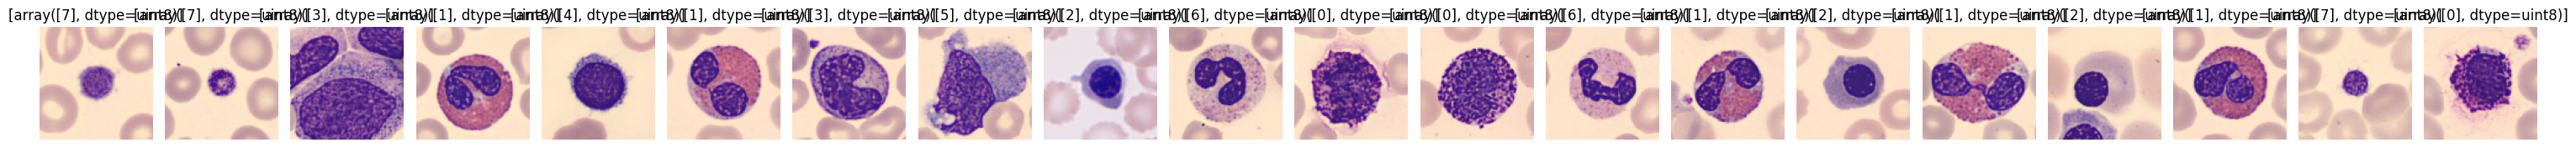

In [8]:
# Display a sample of images from the training-validation dataset
# plot the type of classes that we have
# see different patterns that the network uses to recognize and classify the images
num_img = 20
random_indices = random.sample(range(len(images)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(30, 30))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(images[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{[labels[idx]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

### 🔍 Inspect the Dataset

In [9]:
# Display information about the dataset
print("Keys in the dataset:", data.files)
print("Shape of images:", data['images'].shape)     # (num_images, height, width, num_channels)
print("Shape of labels:", data['labels'].shape)     # (num_images, num_classes)
print("Number of images without the artifacts:", images.shape[0])
print("Image dimensions:", images.shape[1:])
print("Number of classes:", len(np.unique(labels)))

Keys in the dataset: ['images', 'labels']
Shape of images: (13759, 96, 96, 3)
Shape of labels: (13759, 1)
Number of images without the artifacts: 11738
Image dimensions: (96, 96, 3)
Number of classes: 8


In [10]:
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
6    2287
1    2134
3    1988
7    1623
2    1063
5     971
0     838
4     834
Name: count, dtype: int64


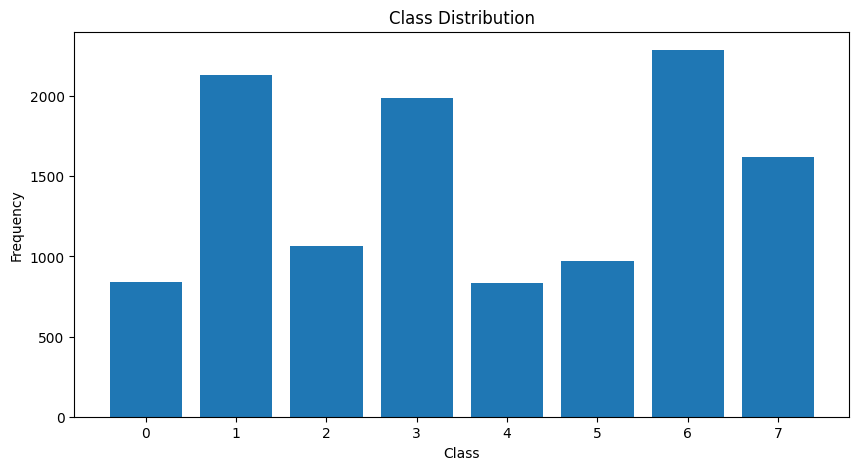

In [11]:
# Display the distribution of classes
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plot the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

## 🧹 Data Preprocessing

In [12]:
# Split the dataset into training_validation (80%) and test (20%) sets
x_train_val, x_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=seed, stratify=labels)

In [13]:
# Print the test set shape
print("Test set shape:")
print("Images:", x_test.shape)
print("Labels:", y_test.shape)

Test set shape:
Images: (2348, 96, 96, 3)
Labels: (2348, 1)


### 📊 Data Normalization

In [14]:
# Split the training_validation set into training (80%) and validation (15%) sets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.15, random_state=seed, stratify=y_train_val)

In [15]:
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (7981, 96, 96, 3)
y_train shape: (7981, 1)
X_val shape: (1409, 96, 96, 3)
y_val shape: (1409, 1)


In [16]:
from keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (7981, 8)
y_val shape: (1409, 8)


### 📚 Data Augmentation

In [17]:
# Augmentation layers to perform data augmentation (https://keras.io/api/keras_cv/layers/augmentation/)
!pip install -q keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.4 MB/s eta 0:00:00


In [18]:
def create_blood_cell_augmentation_pipeline(value_range=(0, 255), seed=42):
    # Define base geometric transformations
    geometric_layers = [
        # Horizontal and vertical flips are safe for cell images
        keras_cv.layers.RandomFlip(mode='horizontal_and_vertical', seed=seed),

        # Small rotations (max 45 degrees) to preserve cell orientation
        keras_cv.layers.RandomRotation(factor=(-0.2,0.3), seed=seed),  # 0.125 = 45 degrees

        # Slight zoom in/out to simulate different microscope magnifications
        keras_cv.layers.RandomZoom(
            height_factor=(-0.3, 0.3),
            width_factor=(-0.3, 0.3),
            seed=seed
        ),

        # Small shifts in position
        keras_cv.layers.RandomTranslation(
            height_factor=0.3,
            width_factor=0.3,
            seed=seed
        )
    ]

    # Define color/intensity transformations
    color_layers = [
        # Modest brightness adjustment
        keras_cv.layers.RandomBrightness(
            factor=[-0.5, 0.5],
            value_range=value_range,
            seed=seed
        ),

        # Slight contrast adjustment
        keras_cv.layers.RandomContrast(
            factor=[0.5, 1],
            value_range=value_range,
            seed=seed
        ),

        # Mild color adjustments
        keras_cv.layers.RandomChannelShift(
            value_range=value_range,
            factor=0.9,  # Reduced from 0.5 to preserve natural cell colors
            seed=seed
        ),

        keras_cv.layers.ChannelShuffle(seed = seed),
    ]

    # Optional: Add subtle noise to simulate microscope artifacts
    noise_layers = [
        tfk.layers.GaussianNoise(stddev=0.5, seed=seed)
    ]

    # Combine all layers
    all_layers = geometric_layers + color_layers + noise_layers

    # Create the pipeline with moderate application rate
    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=all_layers,
        augmentations_per_image=4,  # Apply 2 random augmentations per image
        rate=1,  # 100% chance of applying augmentation to each image
        seed=seed
    )

    return pipeline

# Create the pipeline instance outside the augment function
pipeline = create_blood_cell_augmentation_pipeline()

print("Augmentation pipeline:", pipeline.layers)

Augmentation pipeline: [<RandomFlip name=random_flip, built=False>, <RandomRotation name=random_rotation, built=False>, <RandomZoom name=random_zoom, built=False>, <RandomTranslation name=random_translation, built=False>, <RandomBrightness name=random_brightness, built=False>, <RandomContrast name=random_contrast, built=False>, <RandomChannelShift name=random_channel_shift, built=True>, <ChannelShuffle name=channel_shuffle, built=False>, <GaussianNoise name=gaussian_noise, built=False>]


In [19]:
def augment(images, labels, epoch):
    # Apply augmentation only in even epochs
    if epoch % 2 == 0:
        # Store original statistics for verification
        # orig_mean = tf.reduce_mean(images)
        # orig_std = tf.math.reduce_std(images)

        # Apply augmentation
        augmented = pipeline(images)

        # Ensure values stay within valid range
        augmented = tf.clip_by_value(augmented, 0, 255)

        # Calculate augmented statistics
        aug_mean = tf.reduce_mean(augmented)
        aug_std = tf.math.reduce_std(augmented)

        # Print statistics every 100 batches (adjust as needed)
        # if tf.equal(tf.random.uniform([], 0, 100, dtype=tf.int32), 0):
        #     tf.print("\nAugmentation Check (even epoch):",
        #             "\nOriginal - Mean:", orig_mean, "Std:", orig_std,
        #             "\nAugmented - Mean:", aug_mean, "Std:", aug_std)

        return augmented, labels
    else:
        # Print statistics occasionally for non-augmented batches
        # if tf.equal(tf.random.uniform([], 0, 100, dtype=tf.int32), 0):
        #     tf.print("\nNo Augmentation (odd epoch):",
        #             "\nMean:", tf.reduce_mean(images),
        #             "\nStd:", tf.math.reduce_std(images))
        return images, labels

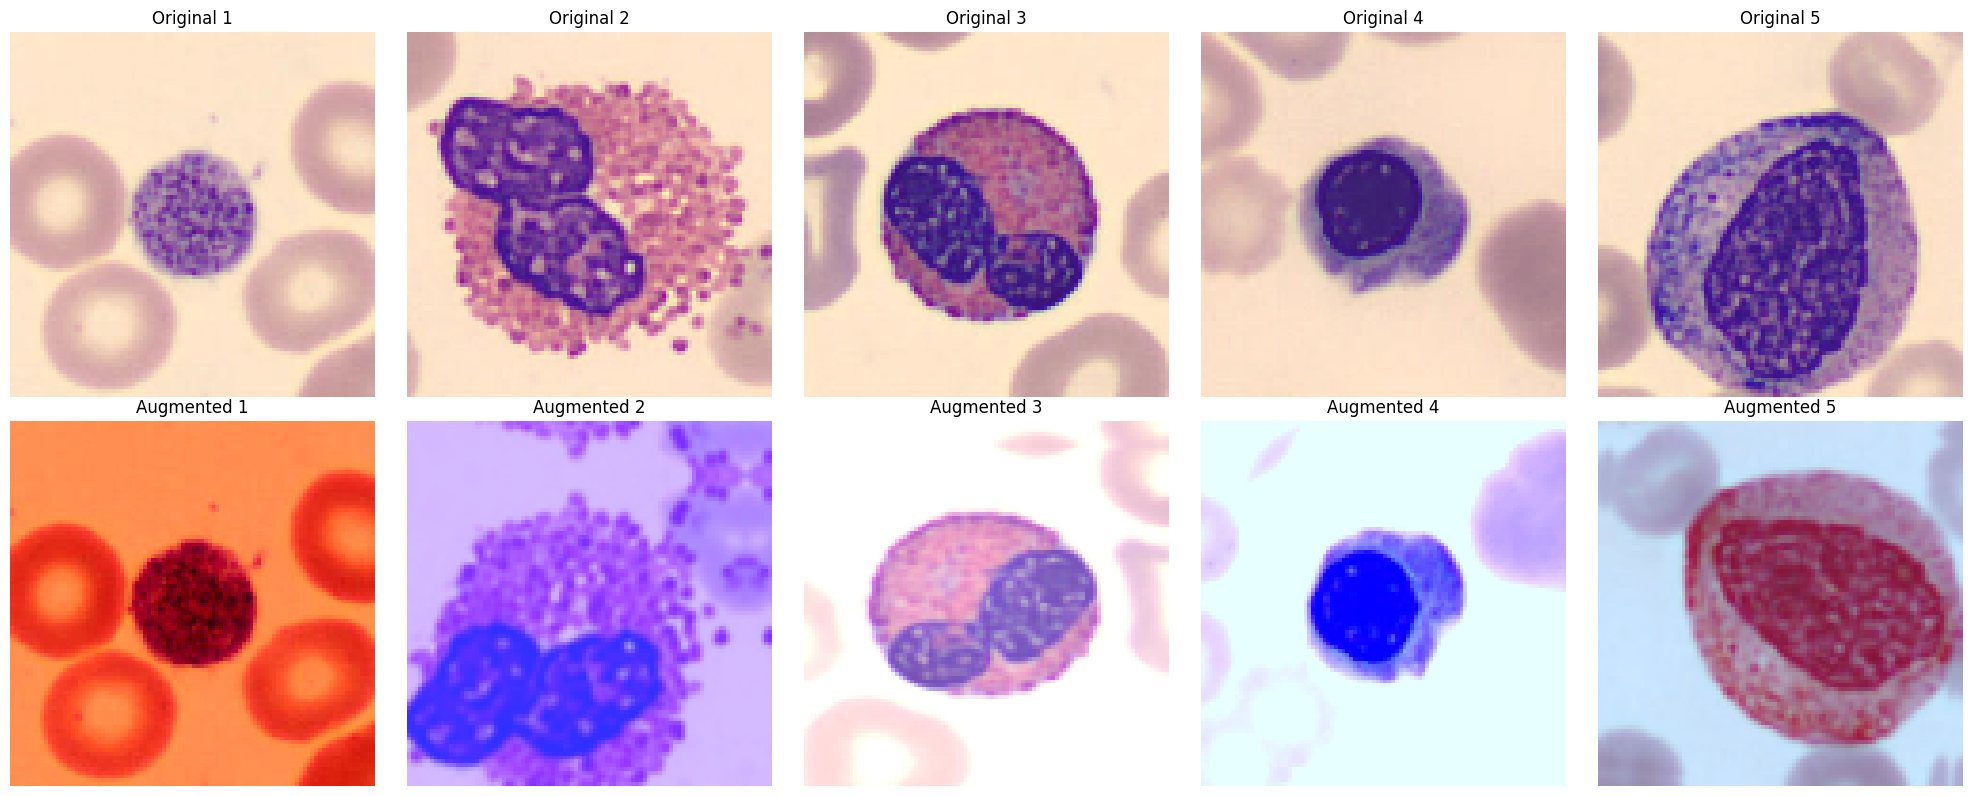

In [20]:
def visualize_augmentations(x_train, y_train, pipeline, num_samples=5):
    # Generate random indices
    random_indices = np.random.choice(len(x_train), size=num_samples, replace=False)

    # Get original images
    original_images = x_train[random_indices]

    # Apply augmentation
    augmented_images = pipeline(original_images)

    # Convert to numpy if needed
    if tf.is_tensor(augmented_images):
        augmented_images = augmented_images.numpy()

    # Ensure values are in valid range [0, 255]
    augmented_images = np.clip(augmented_images, 0, 255)

    # Convert both to uint8 for consistent visualization
    if augmented_images.dtype != np.uint8:
        augmented_images = augmented_images.astype(np.uint8)

    # Plotting
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    # Plot original images on top row
    for i, ax in enumerate(axes[0]):
        ax.imshow(original_images[i])
        ax.set_title(f'Original {i+1}')
        ax.axis('off')

    # Plot augmented images on bottom row
    for i, ax in enumerate(axes[1]):
        ax.imshow(augmented_images[i])
        ax.set_title(f'Augmented {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmentations(x_train, y_train, pipeline)

## 🧮 Define Network Parameters

In [21]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [22]:
# Input shape for the model
input_shape = images.shape[1:]
print(f"Input shape: {input_shape}")

# Number of classes in the dataset
output_shape = len(np.unique(labels))
print(f"Output shape: {output_shape}")


Input shape: (96, 96, 3)
Output shape: 8


In [23]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

# Apply augmentation to the training dataset using the augment function
train_dataset = train_dataset.map(lambda x, y: augment(x, y, epochs), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

In [25]:
print("Augmentation pipeline:", pipeline.layers)

Augmentation pipeline: [<RandomFlip name=random_flip, built=True>, <RandomRotation name=random_rotation, built=True>, <RandomZoom name=random_zoom, built=True>, <RandomTranslation name=random_translation, built=True>, <RandomBrightness name=random_brightness, built=True>, <RandomContrast name=random_contrast, built=True>, <RandomChannelShift name=random_channel_shift, built=True>, <ChannelShuffle name=channel_shuffle, built=True>, <GaussianNoise name=gaussian_noise, built=True>]


## 🏋️‍♂️ Model Definition

In [26]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.regularizers import l2

l2_reg = 0.001

def se_block(inputs, l2_reg=l2_reg, ratio=8):
    if len(inputs.shape) == 4:
        filters = inputs.shape[-1]

        x = tfkl.GlobalAveragePooling2D()(inputs)
        x = tfkl.Reshape((1, 1, filters))(x)
        x = tfkl.Dense(filters // ratio, activation=tf.keras.activations.swish, kernel_regularizer=l2(l2_reg))(x)
        x = tfkl.Dense(filters, activation='sigmoid', kernel_regularizer=l2(l2_reg))(x)
        x = tfkl.Reshape((1, 1, filters))(x)

        return tfkl.multiply([inputs, x])
    else:
        filters = inputs.shape[-1]

        x = tfkl.Dense(filters // ratio, activation=tf.keras.activations.swish, kernel_regularizer=l2(l2_reg))(inputs)
        x = tfkl.Dense(filters, activation='sigmoid', kernel_regularizer=l2(l2_reg))(x)

        return tfkl.multiply([inputs, x])

def mnv3_model(input_shape = input_shape, output_shape = output_shape, learning_rate = learning_rate, l2_reg=l2_reg, seed = seed):
  tf.random.set_seed(seed)

  inputs = tfkl.Input(shape=input_shape, name='Input')
  # preprocessed_inputs = tfk.layers.Lambda(preprocess_input)(inputs)

  base_model = tfk.applications.MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False  # Freeze base model initially

  #x = base_model(preprocessed_inputs)
  x = base_model(inputs)

  # Custom classification head
  x = se_block(x)
  x = tfkl.GlobalAveragePooling2D()(x)
  x = tfkl.Dense(128, activation=tf.keras.activations.swish, kernel_regularizer=l2(l2_reg))(x)
  x = tfkl.BatchNormalization()(x)
  x = se_block(x, l2_reg=l2_reg)
  x = tfkl.Dropout(0.3)(x)
  x = tfkl.Dense(64, activation=tf.keras.activations.swish, kernel_regularizer=l2(l2_reg))(x)
  x = tfkl.BatchNormalization()(x)
  x = se_block(x, l2_reg=l2_reg)
  x = tfkl.Dropout(0.3)(x)
  x = tfkl.Dense(32, activation=tf.keras.activations.swish, kernel_regularizer=l2(l2_reg))(x)
  x = tfkl.BatchNormalization()(x)
  x = se_block(x, l2_reg=l2_reg)
  x = tfkl.Dropout(0.3)(x)

  outputs = tfkl.Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_reg), name='Output')(x)

  model = tfk.Model(inputs=inputs, outputs=outputs, name='Model')

  return model

model = mnv3_model()


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Set the network model layers as trainable
model.get_layer('MobileNetV3Large').trainable = True
# extraction of a single layer from the network

# Set all MobileNetV3Small layers as non-trainable
for layer in model.get_layer('MobileNetV3Large').layers:
    layer.trainable = False
# batch notmalization is best kept freeze!!! so it's important to have a way
# to separate the parts we want to freeze and the ones that we want to adjust to out task

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('MobileNetV3Large').layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.trainable = True # train after a certain point
        # print(i, layer.name, type(layer).__name__, layer.trainable)

# Set the number of layers to freeze
N = 140

# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('MobileNetV3Large').layers[:N]):
    layer.trainable = False # non-trainble layers

# Print layer indices, names, and trainability status
# for i, layer in enumerate(model.get_layer('MobileNetV3Large').layers):
#     print(i, layer.name, layer.trainable)

In [30]:
model.summary(expand_nested=True, show_trainable=True)

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)     │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ cast (Cast)            │ (None, 96, 96, 3)    │            0 │ Input[0][0]         │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ lambda (Lambda)        │ (None, 96, 96, 3)    │            0 │ cast[0][0]          │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ MobileNetV3Large       │ (None, 3, 3, 960)    │    2,996,352 │ lambda[0][0]        │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ input_layer       │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ rescaling         │ (None, 96, 96, 3)    │            0 │ -                   │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv (Conv2D)     │ (None, 48, 48, 16)   │          432 │ -                   │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ conv_bn           │ (None, 48, 48, 16)   │           64 │ -                   │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ activation        │ (None, 48, 48, 16)   │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 48, 48, 16)   │          144 │ -                   │    N    │
│ expanded_conv_depthwi… │                      │              │                     │         │
│ (DepthwiseConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 48, 48, 16)   │           64 │ -                   │    N    │
│ expanded_conv_depthwi… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ re_lu (ReLU)      │ (None, 48, 48, 16)   │            0 │ -                   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 48, 48, 16)   │          256 │ -                   │    N    │
│ expanded_conv_project  │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 48, 48, 16)   │           64 │ -                   │    N    │
│ expanded_conv_project

 Total params: 3,367,964 (12.85 MB)

 Trainable params: 2,397,316 (9.15 MB)

 Non-trainable params: 970,648 (3.70 MB)

In [31]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

## 🧠 Training

In [32]:
# Patience
patience = 10
print(f"Patience: {patience}")

Patience: 10


In [33]:
# EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# ReduceLROnPlateau
reduceLRonPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

callbacks = [early_stopping, reduceLRonPlateau]

### 🚂 Train the Model

In [34]:
# Train the model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = labels.reshape(-1)  # This converts your (11738, 1) array to (11738,)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),  # Use the labels of your dataset
    y=labels
)

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))


history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                    validation_data=val_dataset, callbacks=callbacks,
                    class_weight=class_weight_dict).history # Pass the dictionary to class_weight

# Validation Accuracy
val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f"Validation Accuracy: {val_accuracy}%")

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 132s 719ms/step - accuracy: 0.4366 - loss: 2.3746 - val_accuracy: 0.8708 - val_loss: 1.1690 - learning_rate: 0.0010
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 541ms/step - accuracy: 0.7933 - loss: 1.2292 - val_accuracy: 0.8772 - val_loss: 0.8438 - learning_rate: 0.0010
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 418ms/step - accuracy: 0.8320 - loss: 0.9649 - val_accuracy: 0.9255 - val_loss: 0.5633 - learning_rate: 0.0010
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.8621 - loss: 0.7914 - val_accuracy: 0.9170 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 410ms/step - accuracy: 0.8688 - loss: 0.7082 - val_accuracy: 0.9354 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 409ms/step - accuracy: 0.8743 - loss: 0.6685 - val_accuracy: 0.9425 - val_loss: 0.3897 - learning_rate: 0.0010
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 412ms/step - accur

### 📦 Save the Model

In [ ]:
# Save the trained model (model name = model_<accuracy>.keras)
filename = f'model_{val_accuracy}.keras'
print(f"Saving model to {filename}")
model.save(filename)

In [ ]:
# Delete the model to free up space
del model

## 📈 Training and Validation Graphs

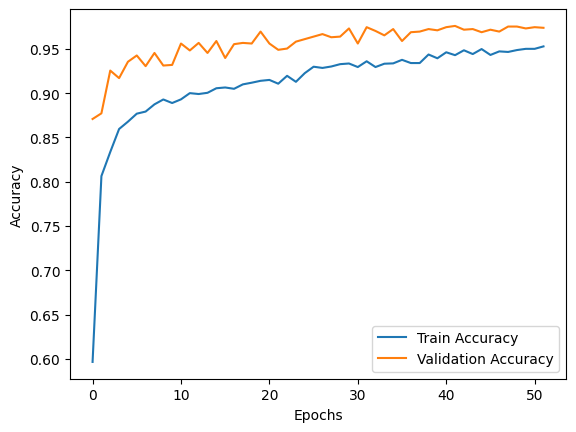

In [37]:
# Plot accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

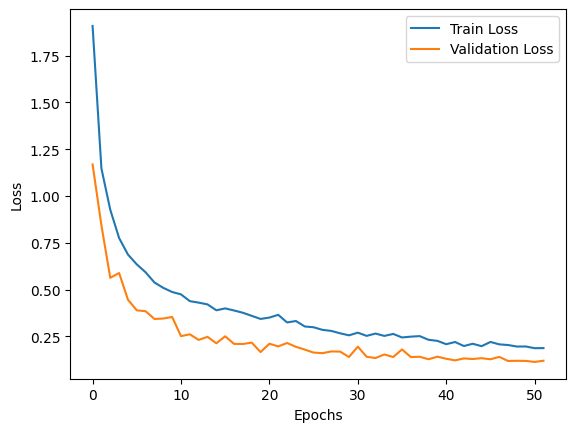

In [38]:
# Plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 📋 Predictions

In [ ]:
# Reload the saved model
# model = tfk.models.load_model(filename, custom_objects={'preprocess_input': preprocess_input})
model = tfk.models.load_model(filename)

In [39]:
import tensorflow as tf

num_classes = 8  # Replace with the actual number of classes in your dataset
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Now, evaluate the model with the encoded target variable
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - accuracy: 0.9722 - loss: 0.1291
Test Accuracy: 97.40%


In [40]:
# Predict labels for the entire test set
predictions = model.predict(x_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (2348, 8)


In [41]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test_encoded, axis=-1) # ?

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

Accuracy score over the test set: 0.974
Precision score over the test set: 0.9747
Recall score over the test set: 0.974
F1 score over the test set: 0.9741


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


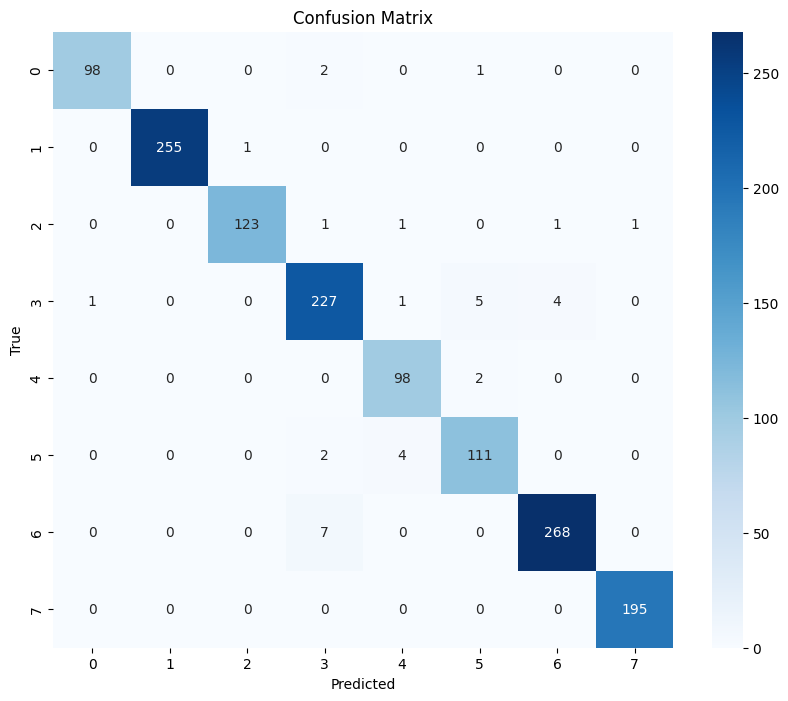

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

if True:
    # Get predictions for the validation set
    y_pred_probs = model.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(output_shape), yticklabels=range(output_shape))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix')
    plt.show()

---